**This Exercise shows how to use Google colab to apply regression models.**
**Copy the Colab notebook and data to your google drive before proceeding.**

Step 1: Connect Google drive that stores the data with your Google Colab Notebook

In [1]:
import numpy as np
import numpy.matlib as matlib
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [3]:
# Replace the ID with ID of file you want to access
# To get this ID, right-click on the name of the appropriate file in your 
downloaded = drive.CreateFile({'id':'1Z6MYK_-FV7J0aTVxoPnjI-E3DdbwMDHG'}) 
downloaded.GetContentFile('time_series_covid_19_confirmed.csv') 

Step 2: Read the Data and verify its format!

In [4]:
import pandas as pd
data = pd.read_csv('time_series_covid_19_confirmed.csv') 
print("The shape of data=",data.shape)
data.head()

The shape of data= (266, 225)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396,5519,5620,5750,5889,6016,6151,6275,6411,6536,6676,6817,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950,31465,31972,32504,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,884,889,889,897,897,897,907,907,918,922,925,925,925,937,939,939,944,955,955,955,963,963,977,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,779,812,851,880,916,932,950,1000,1078,1109,1148,1164,1199,1280,1344,1395,1483,1538,1572,1672,1679,1735,1762,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551


Step 3: Original data has [266x225] dimensions. Let's use only 50 rows and 100 columns.

In [68]:
rows=50
cols=100
data_new=data.iloc[0:rows,4:cols+4]
print(data_new.shape)

(50, 100)


In [69]:
#view the sub-sectioned data
data_new.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27


Step 4: Convert the Tablular data to format {X,Y}, where X={Longitude, Latitude, Date}, Y={#infected}

In [70]:
# Finding the date indices
import matplotlib.pyplot as plt
data_row=data_new.sum(axis=0)
days=range(0,data_row.shape[0])
days_mat=matlib.repmat(np.array(days),data_new.shape[0],1)
print(days_mat.shape)

(50, 100)


In [72]:
# Let's create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)
for r in range(days_mat.shape[0]): #all locations
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_new[r,:],((days_mat.shape[1],1)))

In [73]:
print(np.shape(X))
#Data Preparation is Done!

(5000, 3)


Step 5: Let's Plot the Data to see the converted Data format!

(5000, 3)


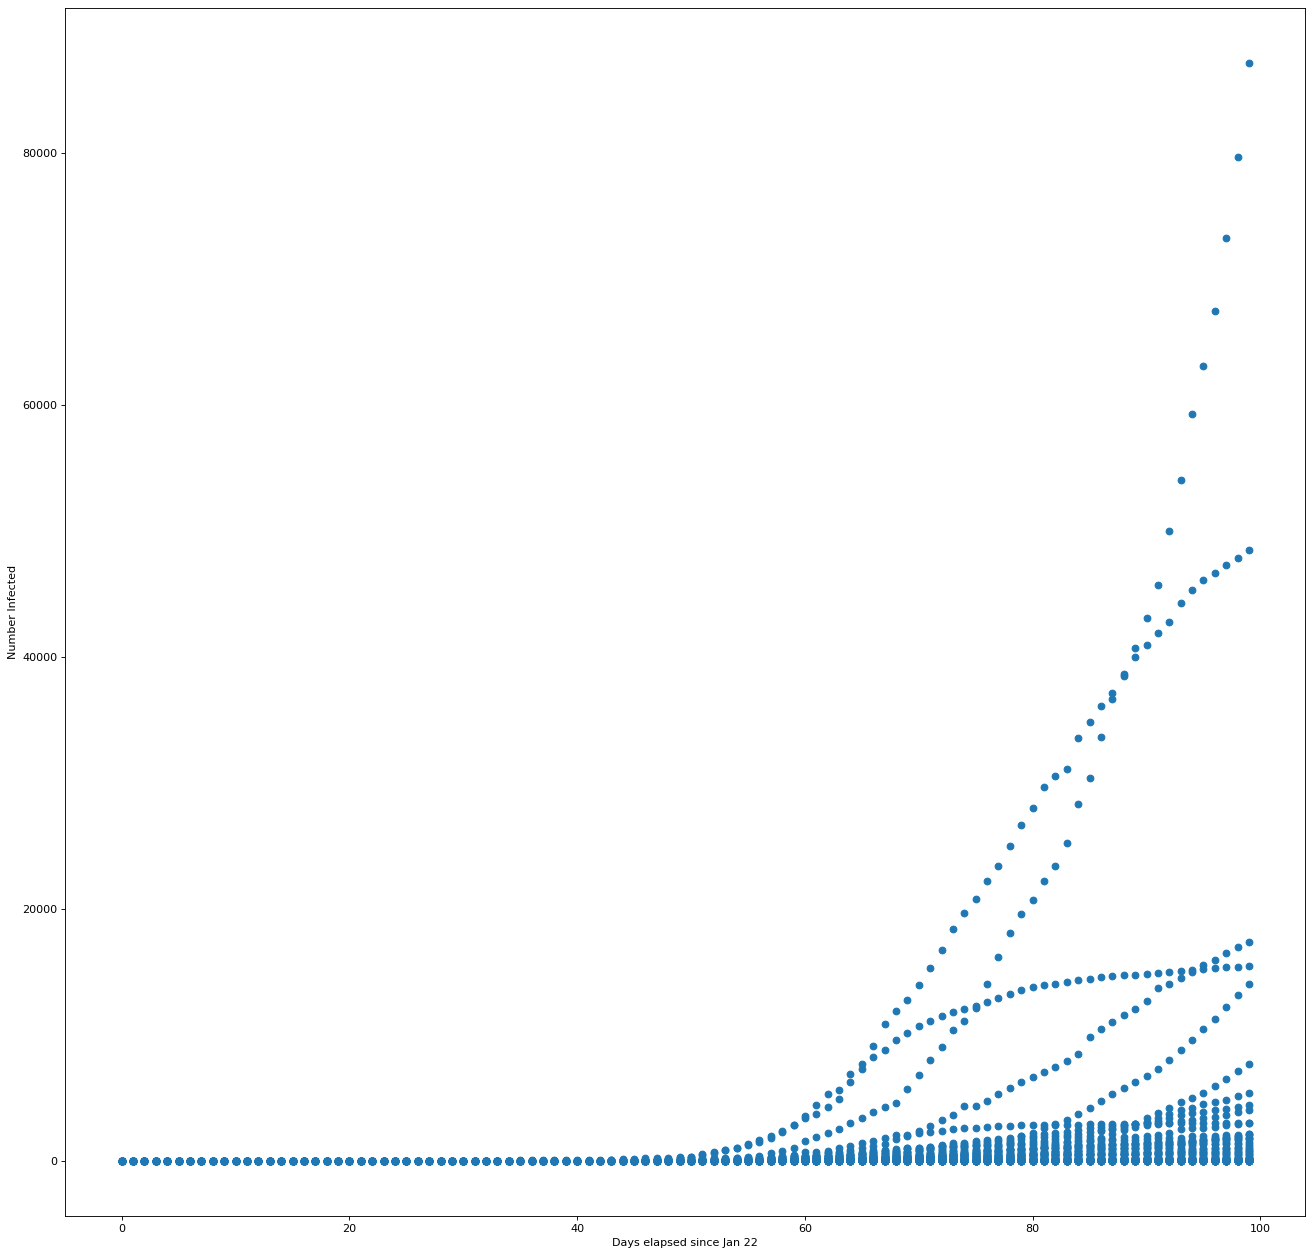

In [74]:
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')
print(np.shape(X))

Step 6: Let's spilt the data to training and test (70% train, 30% test)

In [75]:
# Goal 1: Fit regression model for (days vs infections)
from sklearn.model_selection import train_test_split
# Split data into train and test
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle = False, stratify = None)

Step 7: Let's fit Polynomial features of degree 3 to the features. This results in dimensions going from 3 to 20!

In [86]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1)
# Transform both the train and test data
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
# Fit the model on train data only
clf.fit(X_train, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 4)
Linear Regression Coefficients are= [[ 0.          7.2775501  -6.34932773 45.15003163]]
constant coefficient= [-1013.25113084]


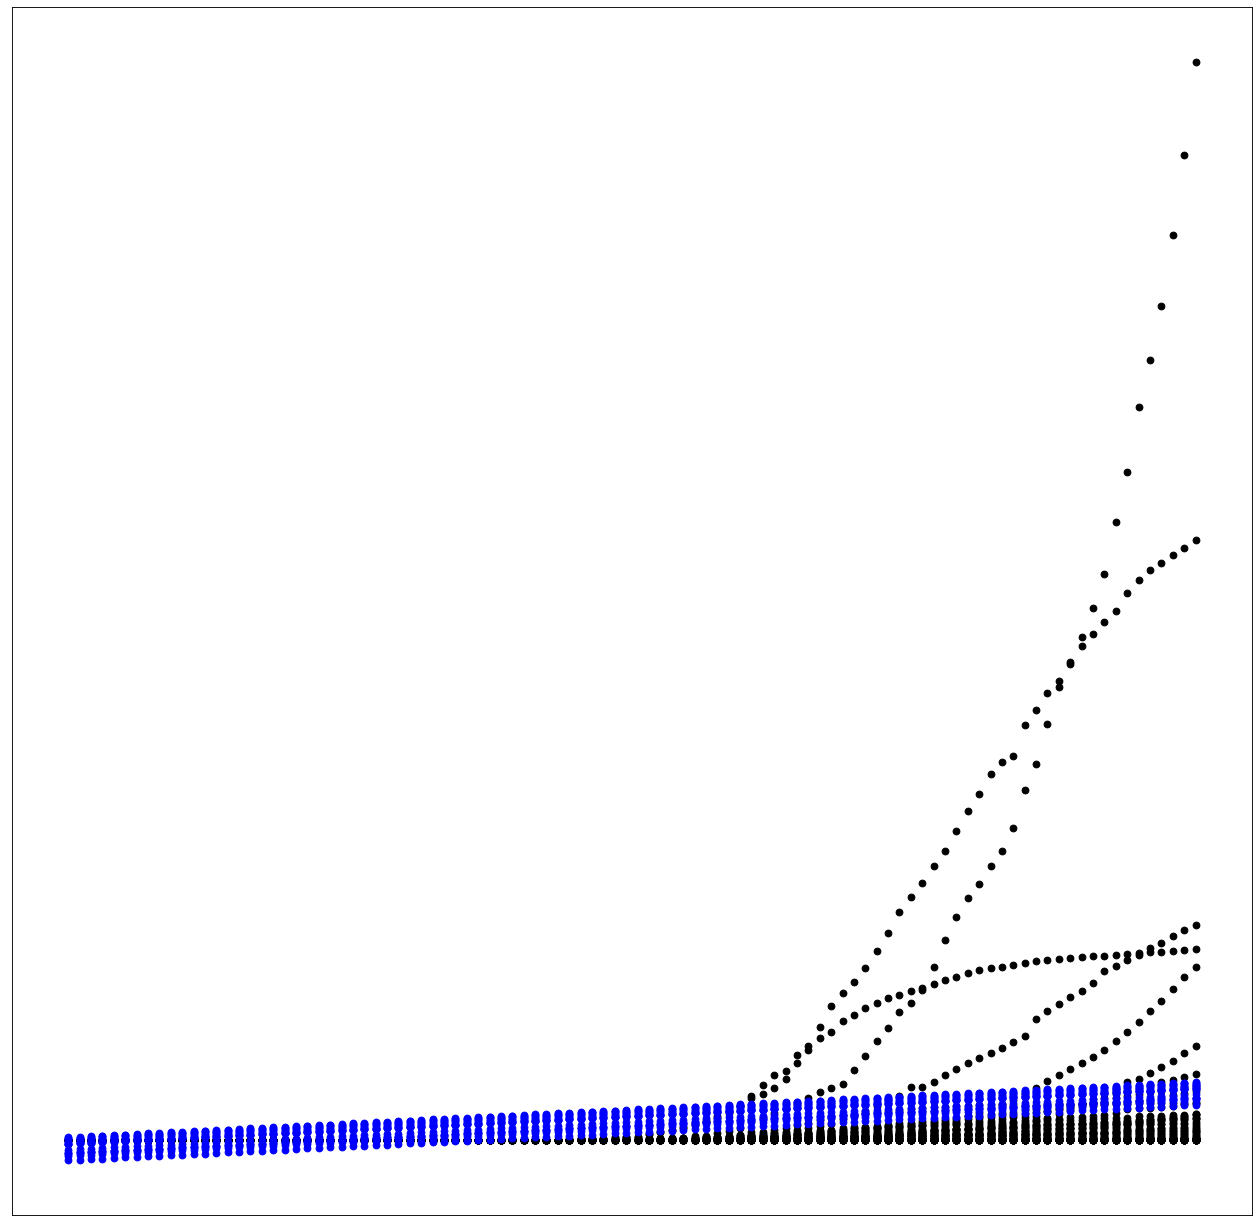

In [87]:
# Predict regression outcome on test data
y_pred = clf.predict(X_test)
# next plot predictions
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In the image above, black points are training and blue ones are test!

In [88]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_test, y_pred))

5024091.612964603


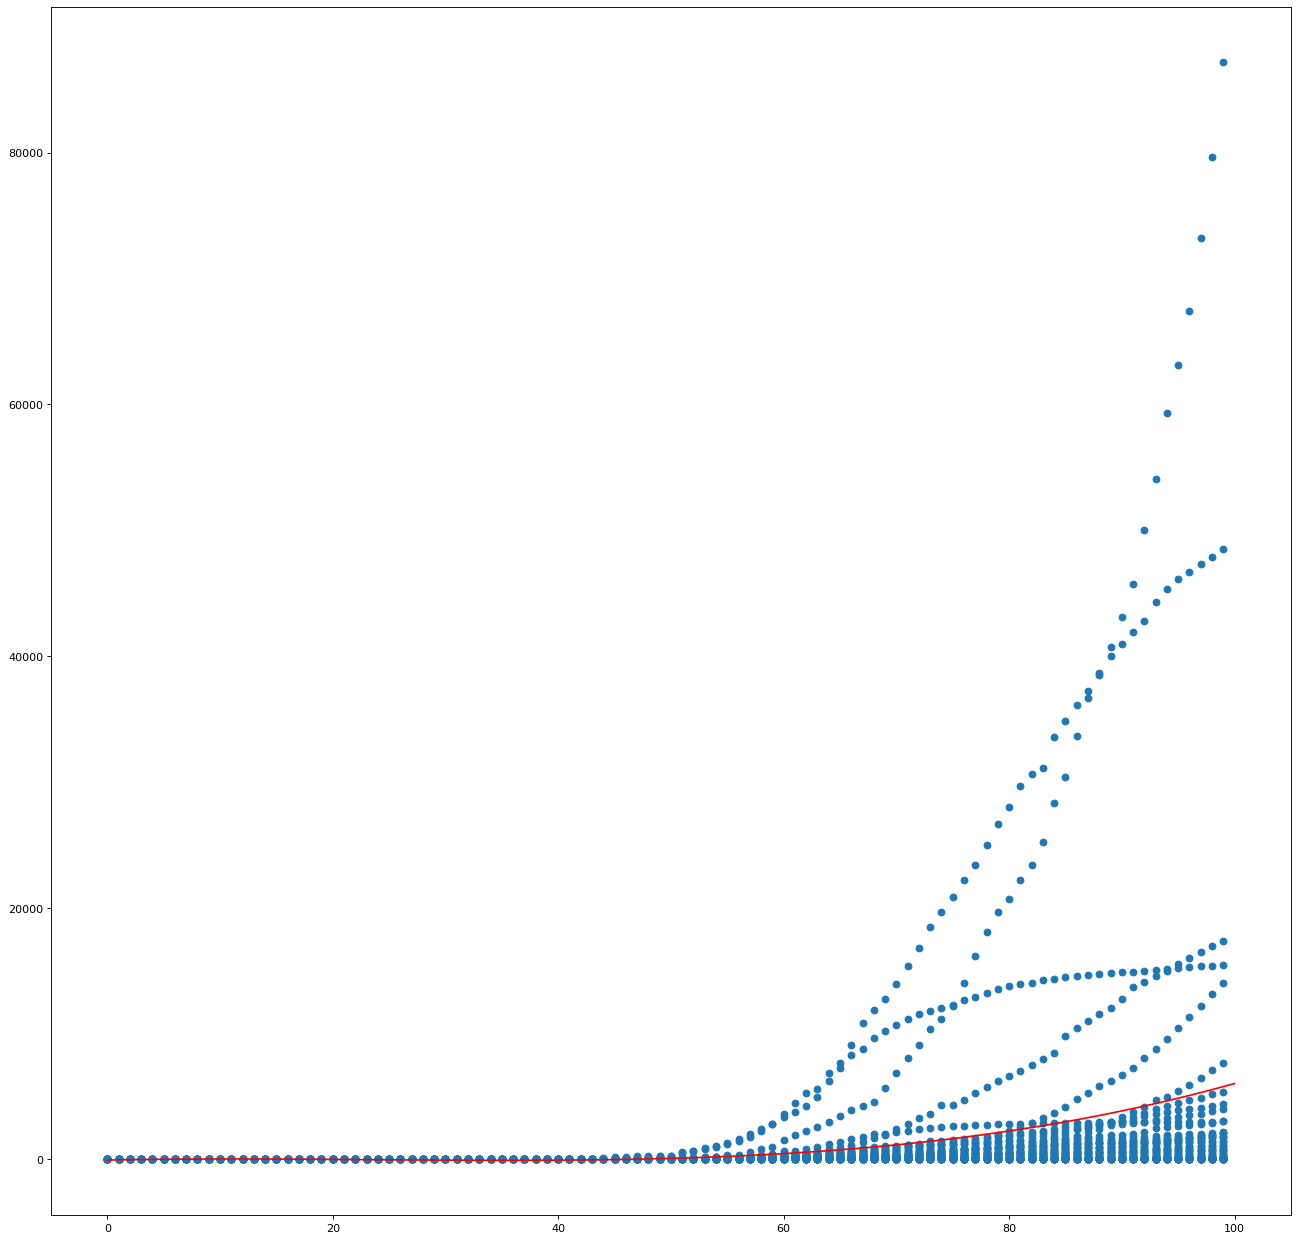

In [89]:
# 1D polynomial regression
model = np.poly1d(np.polyfit(np.transpose(X_train_1[:,2]), np.transpose(y_train[:,0]), 3))

model_x = np.linspace(0, 100, 100)
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.plot(model_x, model(model_x),'r')
plt.show()

In [90]:
#Assignment: Report the mean squared error for prediction using differnt degrers of Polynomial Regression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#1. Report the best model for this data
# a) Degree 3 -> MSE = 20560548.002745174
# b) Degree 2 -> MSE = 22409841.314146668
# c) Degree 1 -> MSE = 23711527.61192565
# Best model is obtained using Polynomial Features of degree 3 although MSE is still quite high. By looking at the plotted data it makes sense that a degree 3 might be a better
# fit because the different curves of infections vs days for each location do present some non-linearities that are perhaps better capture using a non-linear model.

#2. Repeat for complete data (Change step 3) and report the best model
#Changed step 3 to consider all the 266 different locations instead of 50 and 221 days instead of 100
# a) Degree 3 -> MSE = 34001833764.346592
# b) Degree 2 -> MSE = 34331186667.30354
# c) Degree 1 -> MSE = 34692587980.73095
# Again, the best model is obtained using Polynomial Features of degree 3 but MSE is even higher.

# 3. Some other interesting experiments with the preprocessing of the data that I have tried:
# a) Splitting the Train and Test data without shuffling might make more sense in this case because we are dealing with a time-series analysis. I guess that ideally we should try 
# to split the data putting 70% of the first consecutive days for each pair of Lat-Lon on the trainning set and the remaining 30% on the test set. In that way you'd train your model 
# with data from the "past" and test it against data from the future.
# By removing the shuffling from the function train_test_split(X, Y, test_size=0.3, random_state=10) -> train_test_split(X, Y, test_size=0.3, shuffle = False, stratify = None)
# we obtain the following results

# On the reduced data set (50 locations and 100 days)
# a.1) Degree 3 -> MSE = 15656502.25247699
# a.2) Degree 2 -> MSE = 10553854.961081525
# a.3) Degree 1 -> MSE = 5024091.612964603
# Best model is obtained using Polynomial Features of degree 1 and a considerably lower MSE when comparing to the results we got on item 1. Probably during the first days of the pandemic
# with lower number of cases the curves resembled a little bit more a linear model.

# On the whole data set (266 locations and 221 days)
# a.1) Degree 3 -> MSE = 89420279719.60722
# a.2) Degree 2 -> MSE = 87590702729.28273
# a.3) Degree 1 -> MSE = 87055639788.59778
# Best model is obtained using Polynomial Features of degree 1 but with a considerably higher MSE when comparing to the results we got on item 2. In this case, considering only the 70% of
# the first consecutive days to train the model might not be a good option. In some places the cases are growing exponentially and but limiting the training data to only the first consecutives
# days the model might not be able to predict this exploding number of cases and that's why the error is higher.










# **Summary and Discussion (10-15 min session at end of Assignment)**
## This exercise is meant to get us all acquainted with Google colab, porting data from google drive to colab and visualizing outcomes. At the end, discuss the following:
1.  Are there any other ways of pre-processing the data with pandas? What commands would you use?
2. How would you optimize the process? i.e. How would you ensure best fit polynomial regresison is selected. Think of the process/steps. 
3. What does the output metric tell you? Can you gauge over-prediction and udner predictions?
